## 개요 

참여중인 딥러닝 스터디 3주차 기록입니다.

* CNN로 MNIST다루기
* 강사님이 주신 샘플코드 참고해서, 나에게 맞추거나 추가공부 진행

## 과제 작성 (MNIST CNN)

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

### 데이터 로드 및 Shape 확인

In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape, Y_train[0])
print(X_test.shape, Y_test.shape, Y_test[0])

(60000, 28, 28) (60000,) 5
(10000, 28, 28) (10000,) 7


Min : 0, Max : 255


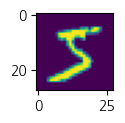

In [3]:
print(f"Min : {X_train[0].min()}, Max : {X_train[0].max()}")
plt.figure(figsize=(1,1))
plt.imshow(X_train[0])

### 3D tensor로 변경 및 float32변환, Normalize

In [4]:
# 3D Tensor
X_train.reshape(60000,28,28,1)
X_test.reshape(10000,28,28,1)

# Float32변환
X_train, X_test = np.array(X_train, np.float32), np.array(X_test, np.float32)

# Normalize (0~255값을 0~1로)
X_train, X_test = X_train / 255., X_test / 255.

### Feature Learning + Fully-connected layer

In [5]:
### 특성 추출 (Feature Learning)

model = Sequential()
model.add(Input(shape=(28, 28, 1)))

# Output계산식(Convolution layer) : (Input - Filter + 2 * Padding) / stride + 1

# 3*3인 Filter(Kernel) 32개, 2번째줄 옵션은 미입력시 기본값 
#  (Valid Padding은 Padding 미적용을 의미)
# → Output(activation map=(26,26,32)) : [(28-3+2*0)/1 + 1] * 32(Filter 수)
# → Weights : (3*3)size*32filter / biases : 32filter
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 strides=(1,1), padding='valid', kernel_initializer='glorot_uniform'))

# 2*2인 최대값만 남기는 Pool, 2번째줄 옵션은 미입력시 기본값
# → Output(activation map=(13,13,32)) : [26/2]
# → Weights and biases : Pooling은 학습이 일어나지 않는다
model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=None, padding='valid'))

# 3*3인 Filter(Kernel) 64개
# → Output(activation map=(11,11,64)) : [(13-3+2*0)/1 + 1] * 64(Filter 수)
# → Weights : (3*3)size*64filter*32activation map / biases : 64filter
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# 2*2인 최대값만 남기는 Pool
# → Output(activation map=(5,5,64)) : [11/2]
# → Weights and biases : Pooling은 학습이 일어나지 않는다
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3*3인 Filter(Kernel) 64개
# → Output(activation map=(3,3,64)) : [(5-3+2*0)/1 + 1] * 64(Filter 수)
# → Weights : (3*3)size*64filter*64activation map / biases : 64filter
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))


### Fully connected Layer

# flatten shape(576) : [3*3*64]
model.add(Flatten())

# 이전 Layer와 결합. Node=64
# parameters(36928) : [576*64(weights)+64(biases)]
model.add(Dense(64, activation='relu'))

# 이전 Layer와 결합. Output = 10
# parameters(650) : [64*10(weights)+10(biases)]
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

### 모델 컴파일(Loss function, optimizer, metrics 설정)

In [6]:
# Loss function은
#  Label = number 인 경우 → sparse_categorical_crossentropy (one-hot이 아니므로 메모리소요가 적다)
#  Label = one-hot 인 경우 → categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 모델 학습

In [7]:
history = model.fit(X_train, Y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9056 - loss: 0.3245
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9861 - loss: 0.0442
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9901 - loss: 0.0313
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9926 - loss: 0.0245
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9953 - loss: 0.0163


### 학습횟수에 따른 Loss(Cost)시각화

In [8]:
# 저장된 값 확인
history.history

{'accuracy': [0.9584500193595886,
  0.9862833619117737,
  0.9898499846458435,
  0.9920166730880737,
  0.9940166473388672],
 'loss': [0.13941822946071625,
  0.04484217241406441,
  0.032598868012428284,
  0.025325138121843338,
  0.01914270594716072]}

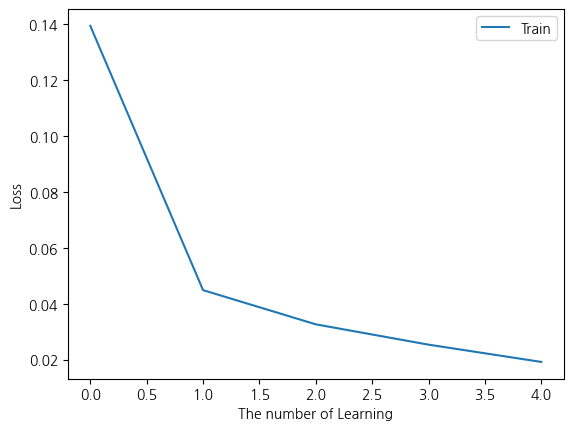

In [9]:
# Plot 시각화
plt.plot(history.history['loss'], label='Train')
plt.xlabel('The number of Learning')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 모델평가

In [10]:
test_result = model.evaluate(X_test, Y_test, verbose=2)
print()
print(test_result)
print(f"Test Loss = {test_result[0]} / Test Accuracy = {test_result[1]}")

313/313 - 1s - 3ms/step - accuracy: 0.9909 - loss: 0.0343

[0.03433739021420479, 0.9908999800682068]
Test Loss = 0.03433739021420479 / Test Accuracy = 0.9908999800682068


### 예측

In [11]:
predictions = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


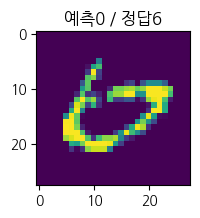

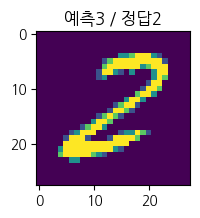

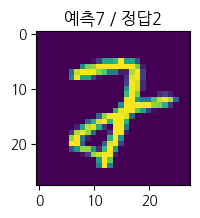

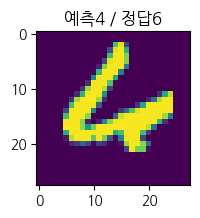

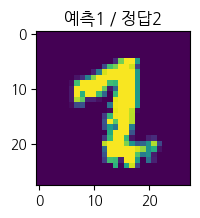

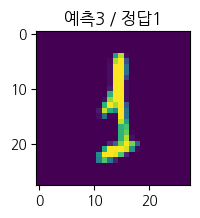

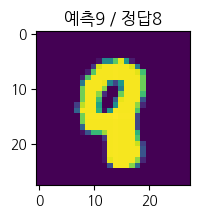

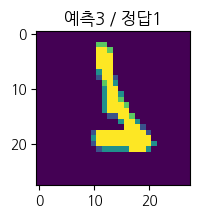

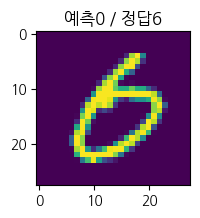

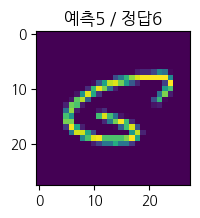

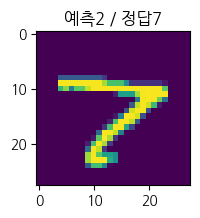

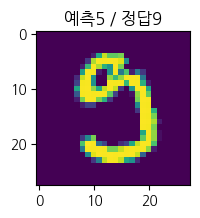

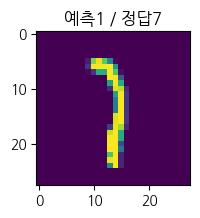

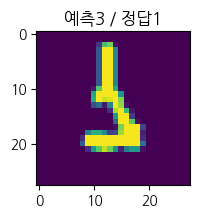

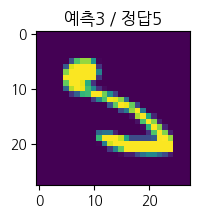

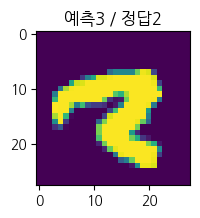

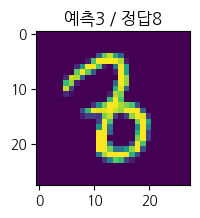

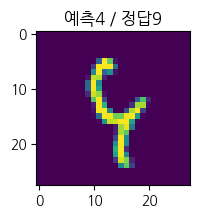

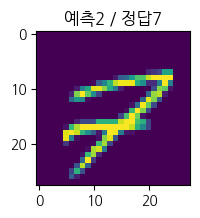

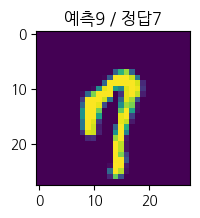

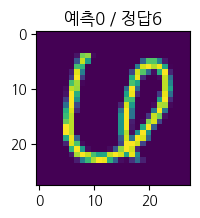

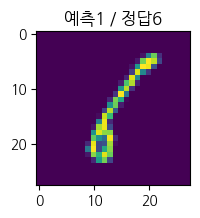

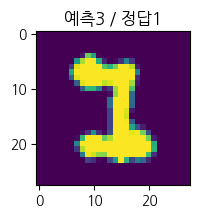

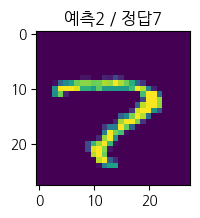

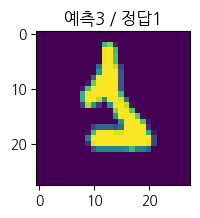

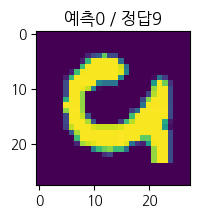

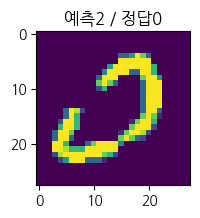

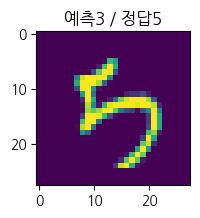

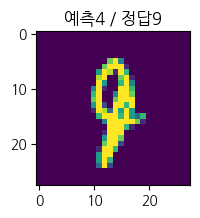

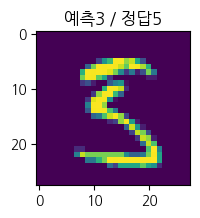

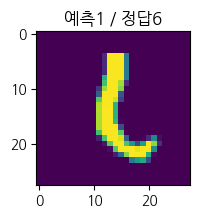

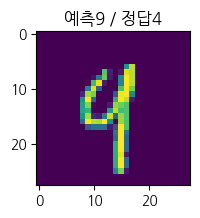

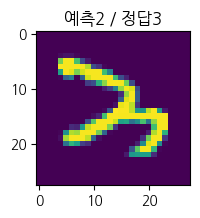

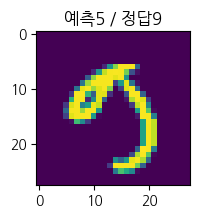

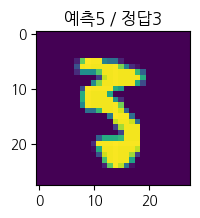

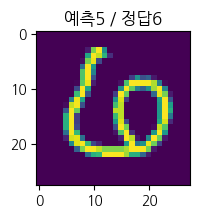

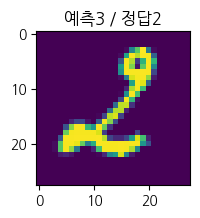

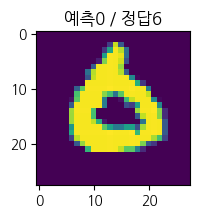

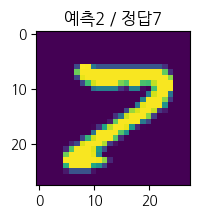

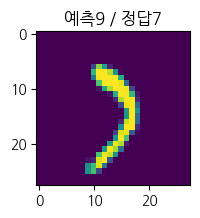

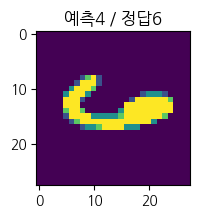

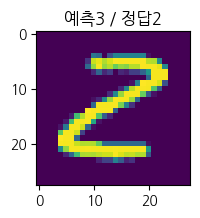

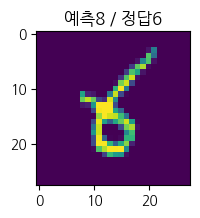

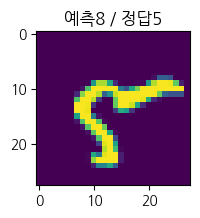

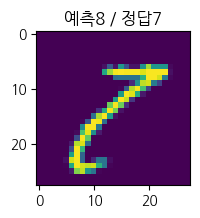

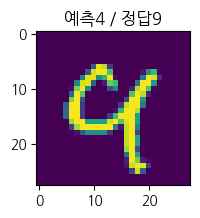

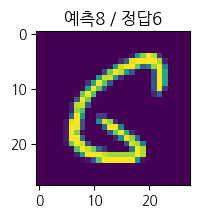

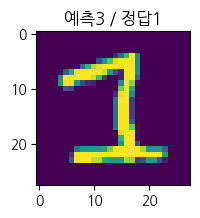

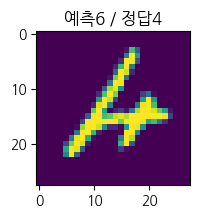

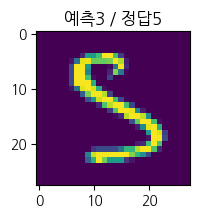

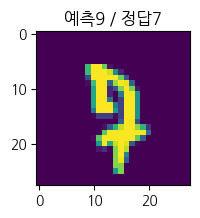

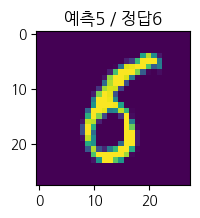

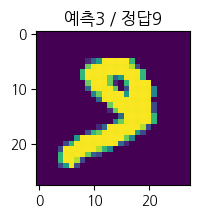

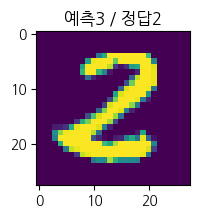

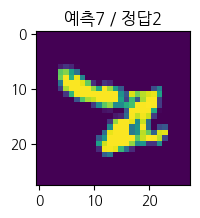

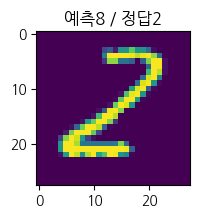

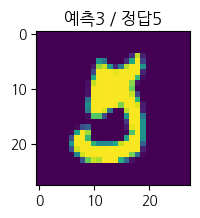

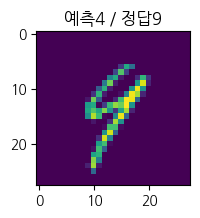

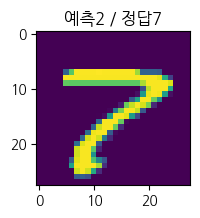

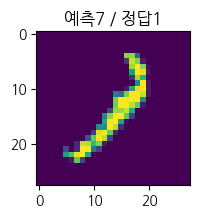

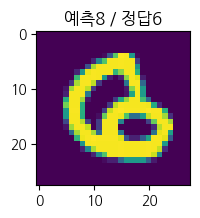

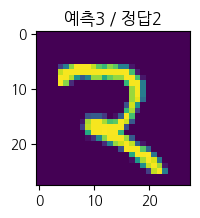

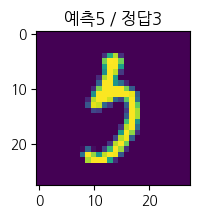

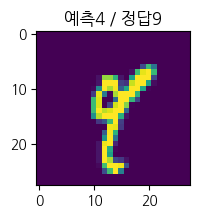

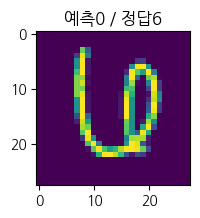

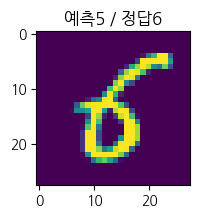

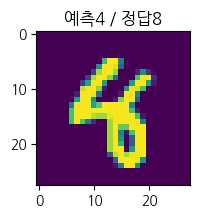

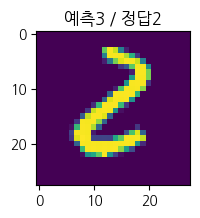

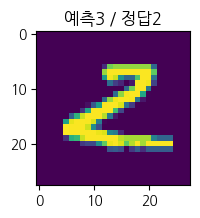

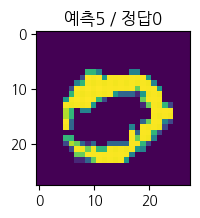

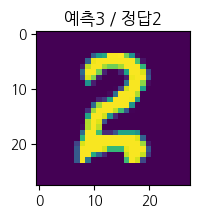

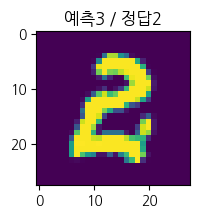

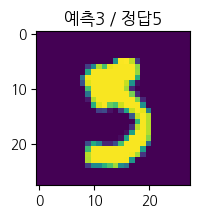

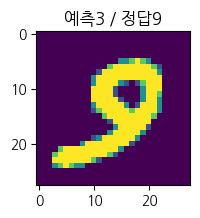

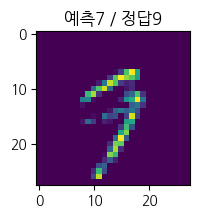

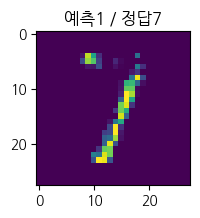

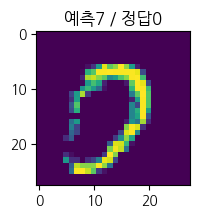

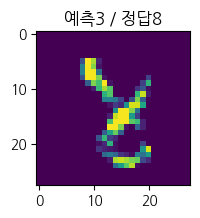

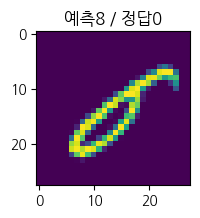

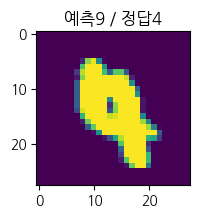

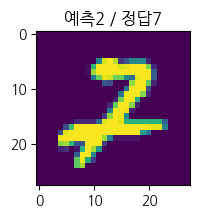

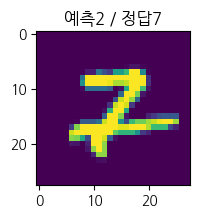

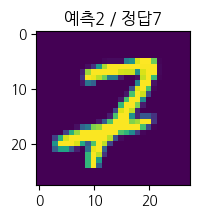

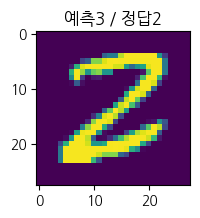

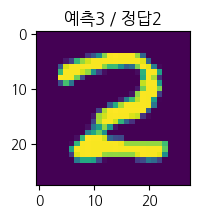

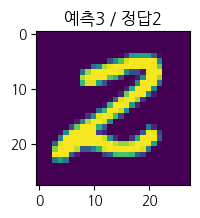

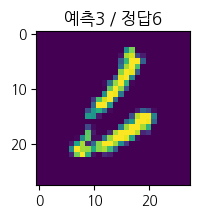

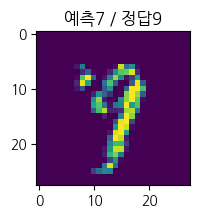

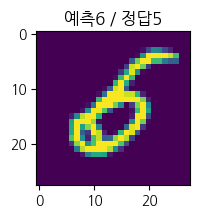

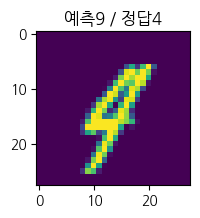

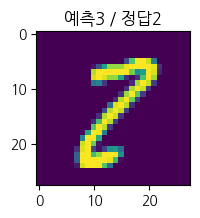

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 10000

for i in range(len(predictions)):
    if np.argmax(predictions[i]) != Y_test[i]:
        plt.figure(figsize=(2,2))
        plt.imshow(X_test[i])
        plt.title(f"예측{np.argmax(predictions[i])} / 정답{Y_test[i]}")